In [1]:
from sklearn.metrics import mean_squared_error

import numpy as np 
import pandas as pd 

import datetime

import csv
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression


from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, TimeDistributed, Bidirectional, Conv1D, ConvLSTM2D


#sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


## LOAD PREPARED DATASET

In [2]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0)
btc_data.index = pd.to_datetime(btc_data.index)

### USE ONLY BTC_Close feature

In [3]:
features = btc_data['BTC_Close'].shift(1).dropna()
target = btc_data['BTC_Close'][1:]
prediction_days = 90

In [4]:
target.values

array([  144.54,   139.  ,   116.99, ...,  4347.11,  3880.76,  4009.97])

In [5]:
features.values

array([  134.21,   144.54,   139.  , ...,  4365.94,  4347.11,  3880.76])

# Univariate LSTM Models

In [6]:
# split a univariate sequence into samples 
def split_sequence(sequence, n_steps): 
    X, y = list(), list() 
    for i in range(len(sequence)):
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the sequence 
        if end_ix > len(sequence)-1: 
            break 
            # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return np.array(X), np.array(y)

In [7]:
# define input sequence 
raw_seq = list(features.values)
# choose a number of time steps 
n_steps = 7
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# split into samples
for i in range(len(X)): 
    print(X[i], y[i])

[ 134.21  144.54  139.    116.99  105.21   97.75  112.5 ] 115.91
[ 144.54  139.    116.99  105.21   97.75  112.5   115.91] 112.3
[ 139.    116.99  105.21   97.75  112.5   115.91  112.3 ] 111.5
[ 116.99  105.21   97.75  112.5   115.91  112.3   111.5 ] 113.57
[ 105.21   97.75  112.5   115.91  112.3   111.5   113.57] 112.67
[  97.75  112.5   115.91  112.3   111.5   113.57  112.67] 117.2
[ 112.5   115.91  112.3   111.5   113.57  112.67  117.2 ] 115.24
[ 115.91  112.3   111.5   113.57  112.67  117.2   115.24] 115.0
[ 112.3   111.5   113.57  112.67  117.2   115.24  115.  ] 117.98
[ 111.5   113.57  112.67  117.2   115.24  115.    117.98] 111.5
[ 113.57  112.67  117.2   115.24  115.    117.98  111.5 ] 114.22
[ 112.67  117.2   115.24  115.    117.98  111.5   114.22] 118.76
[ 117.2   115.24  115.    117.98  111.5   114.22  118.76] 123.01
[ 115.24  115.    117.98  111.5   114.22  118.76  123.01] 123.5
[ 115.    117.98  111.5   114.22  118.76  123.01  123.5 ] 121.99
[ 117.98  111.5   114.22  118.7

In [8]:
#cut 
X_train = X[:len(X)-prediction_days]
X_test = X[len(X)-prediction_days:]
y_train = y[:len(y)-prediction_days]
y_test = y[len(y)-prediction_days:]

In [9]:
#normalize
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
X_train = X_min_max_scaler.fit_transform(X_train)
X_test = X_min_max_scaler.transform(X_test)
y_train = y_min_max_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_min_max_scaler.transform(y_test.reshape(-1, 1))

In [10]:
# split a univariate sequence into samples 
# reshape from [samples, timesteps] into [samples, timesteps, features] 
n_features = 1 #unvariate so we predict 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [11]:
X_train.shape

(1939, 7, 1)

### Vanilla LSTM

In [56]:
# define model 
model = Sequential() 
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features))) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')


In [36]:
#import tensorflow

In [37]:
#!pip install Tensorboard

In [58]:
# fit model 
model.fit(X_train, y_train, epochs=50, verbose=0)

In [64]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [65]:
preds = model.predict(X_test, verbose=0)

In [66]:
preds = y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test = y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

In [67]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

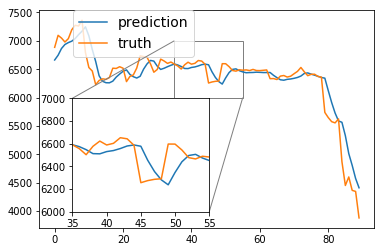

In [68]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(preds.ravel(), label='prediction')
ax1.plot(y_test.ravel(), label='truth')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset

axins = zoomed_inset_axes(ax1, 2, loc=3, bbox_to_anchor=(82, 47)) # zoom-factor: 2

axins.plot(preds.ravel())
axins.plot(y_test.ravel())
axins.set_xlim([35, 55])
axins.set_ylim([6000, 7000])


mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [69]:
np.sqrt(mean_squared_error(y_test,preds))

231.75326548880889

### Stacked LSTM


In [47]:
#cut 
X_train = X[:len(X)-prediction_days]
X_test = X[len(X)-prediction_days:]
y_train = y[:len(y)-prediction_days]
y_test = y[len(y)-prediction_days:]

In [48]:
#normalize
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
X_train = X_min_max_scaler.fit_transform(X_train)
X_test = X_min_max_scaler.transform(X_test)
y_train = y_min_max_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_min_max_scaler.transform(y_test.reshape(-1, 1))

In [49]:
# split a univariate sequence into samples 
# reshape from [samples, timesteps] into [samples, timesteps, features] 
n_features = 1 #unvariate so we predict 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [112]:
# define model 
model = Sequential() 
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features))) 
model.add(LSTM(50, activation='relu')) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')


In [113]:
# fit model 
model.fit(X_train, y_train, epochs=50, verbose=0)

In [50]:
# demonstrate prediction 
preds = model.predict(X_test, verbose=0)

In [51]:
preds = y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test = y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

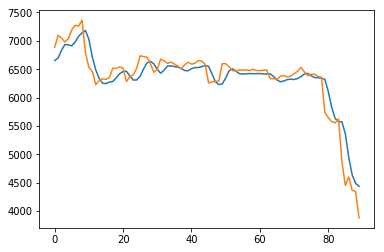

In [116]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.show()

In [117]:
np.sqrt(mean_squared_error(y_test,preds))

224.47630105664712

### Bidirectional LSTM

In [52]:
#cut 
X_train = X[:len(X)-prediction_days]
X_test = X[len(X)-prediction_days:]
y_train = y[:len(y)-prediction_days]
y_test = y[len(y)-prediction_days:]

In [53]:
#normalize
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
X_train = X_min_max_scaler.fit_transform(X_train)
X_test = X_min_max_scaler.transform(X_test)
y_train = y_min_max_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_min_max_scaler.transform(y_test.reshape(-1, 1))

In [54]:
# split a univariate sequence into samples 
# reshape from [samples, timesteps] into [samples, timesteps, features] 
n_features = 1 #unvariate so we predict 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [27]:
# define model 
model = Sequential() 
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features))) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')

In [28]:
# fit model 
model.fit(X_train, y_train, epochs=200, verbose=0)

In [55]:
# demonstrate prediction 
preds = model.predict(X_test, verbose=0)

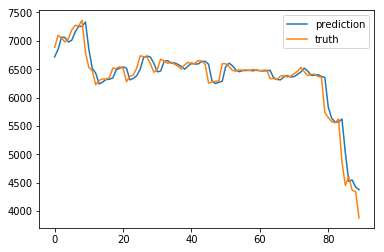

In [56]:
preds = y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test = y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [57]:
np.sqrt(mean_squared_error(y_test,preds))

175.31000625007172

## COMPARE TO PREVIOUS DAY

We can clearly imagine predictions is looks like shifted truth data. Let's check if works

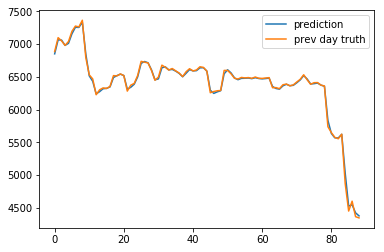

In [33]:
plt.plot(preds.ravel()[1:], label='prediction')
plt.plot(y_test.ravel()[:-1], label='prev day truth')
plt.legend()
plt.show()

In [34]:
np.sqrt(mean_squared_error(y_test.ravel()[:-1],preds.ravel()[1:]))

29.253276844892195

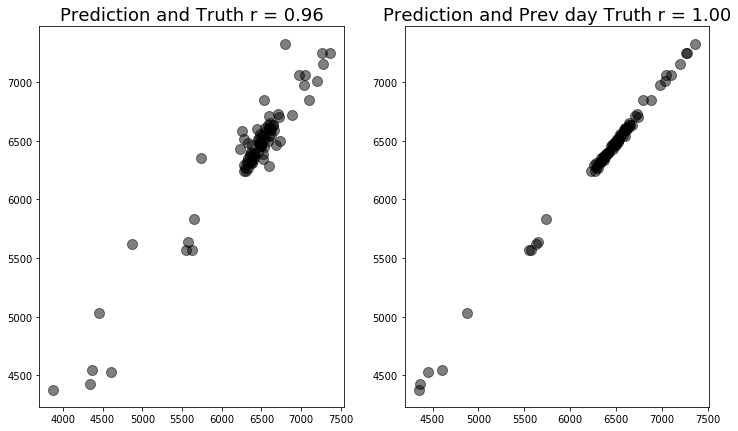

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# actual correlation
corr = np.corrcoef(y_test, preds)[0][1]
ax1.scatter(y_test, preds, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('Prediction and Truth '+'r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
daybefore = y_test.ravel()[:-1]
preds = preds.ravel()[1:]
corr = np.corrcoef(daybefore, preds)[0][1]
ax2.scatter(daybefore, preds, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('Prediction and Prev day Truth '+'r = {:.2f}'.format(corr), fontsize=18);